Author: Saman Paidar Nia

In [1]:
# Get important libraries for this class.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import warnings
import csv
import random
import math
#--------------------------------------------------------
from tensorflow.python.ops import control_flow_ops
from IPython.display import clear_output
from scipy.spatial.distance import squareform, pdist
from sklearn.preprocessing import normalize
from numpy import linalg as LA
from scipy.cluster.vq import kmeans, vq
from sklearn.metrics import normalized_mutual_info_score
from tqdm import tqdm

In [2]:
class Similarity_func:
    def sigmoidal_normalize(self, X):
        X= (X - min(X)) / (max(X) - min(X))
        return X

In [3]:
class Cosine_Similarity(Similarity_func):
    def get_matrix(self, data):
        data = normalize(data, axis=0)
        m = squareform(pdist(data, 'cosine'))
        m = np.dot(LA.matrix_power(np.diag(np.sum(m, 0)), -1), m)
        m = np.apply_along_axis(self.sigmoidal_normalize, 1, m)
        np.fill_diagonal(m, 0.)
        return m

In [4]:
class Similarity_Dataset_Iterator():
    def __init__(self, data, labels, similarity):
        self.data = data
        self.labels = labels
        self.matrix = similarity.get_matrix(data)
        self.data_size = self.matrix.shape[0]
        self.current_index = 0
    def next_batch(self, num):
        data=self.matrix.transpose()
        labels=self.labels
        idx = np.arange(0 , len(data))
        np.random.shuffle(idx)
        idx = idx[:num]
        data_shuffle = [data[ i] for i in idx]
        labels_shuffle = [labels[ i] for i in idx]
        return data_shuffle, labels_shuffle
    def whole_dataset(self):
        return (self.matrix.transpose(), self.labels)

In [5]:
def read_breast_cancer_data(similarity):
    with open('../Autoencoder_vs_Spectral_on_Breast_Cancer/Breast_Cancer_Dataset/breast_cancer.csv') as csvfile:        
        csvreader = csv.reader(csvfile)
        next(csvreader, None) # skip header
        dataset = list(csvreader)
    random.shuffle(dataset)
    datatrain = dataset[:int(len(dataset))]
    data = [data[:30] for data in datatrain]
    labels = [data[30] for data in datatrain]   
    return Similarity_Dataset_Iterator(data, labels, similarity)

In [6]:
# Call Nearest_Neighbors_Similarity or Cosine_Similarity as similarity dataset.
data_set_train = read_breast_cancer_data(Cosine_Similarity())

In [7]:
def k_means_(X, n_cluster):
    kmeans_centroids,_ =  kmeans(X,n_cluster)
    kmeans_, _ = vq(X, kmeans_centroids)
    return kmeans_

In [8]:
def spectral_clustering(X, n_component, n_cluster):
    D_ = np.matrix(np.diag(np.sum(X,0)))
    D_ = D_**(-1)
    L = np.dot(np.dot(D_, X),D_)
    eigenvectors = np.linalg.eig(L)[1]
    X = np.real(eigenvectors[:,0:n_component])
    X = normalize(X, norm='l2', axis=0)
    return k_means_(X, n_cluster), X

In [9]:
n_input = data_set_train.data_size # number of input data which is 569.
# The autoencoder hidden layers
n_hidden_1 = 512
n_hidden_2 = 256
n_hidden_3 = 128
n_hidden_4 = 64
n_hidden_5 = 32

In [10]:
def encoder(x, n_code, phase_train):    
    with tf.variable_scope("encoder"):        
        with tf.variable_scope("hidden_1"):
            hidden_1 = layer(x, [n_input, n_hidden_1], [n_hidden_1], phase_train)
        with tf.variable_scope("hidden_2"):
            hidden_2 = layer(hidden_1, [n_hidden_1, n_hidden_2], [n_hidden_2], phase_train)
        with tf.variable_scope("hidden_3"):
            hidden_3 = layer(hidden_2, [n_hidden_2, n_hidden_3], [n_hidden_3], phase_train)
        with tf.variable_scope("hidden_4"):
            hidden_4 = layer(hidden_3, [n_hidden_3, n_hidden_4], [n_hidden_4], phase_train)
        with tf.variable_scope("hidden_5"):
            hidden_5 = layer(hidden_4, [n_hidden_4, n_hidden_5], [n_hidden_5], phase_train)
        with tf.variable_scope("code"):
            code = layer(hidden_5, [n_hidden_5, n_code], [n_code], phase_train)
    return code

In [11]:
def decoder(code, n_code, phase_train):
    with tf.variable_scope("decoder"):
        with tf.variable_scope("hidden_1"):
            hidden_1 = layer(code, [n_code, n_hidden_5], [n_hidden_5], phase_train)
        with tf.variable_scope("hidden_2"):
            hidden_2 = layer(hidden_1, [n_hidden_5, n_hidden_4], [n_hidden_4], phase_train)
        with tf.variable_scope("hidden_3"):
            hidden_3 = layer(hidden_2, [n_hidden_4, n_hidden_3], [n_hidden_3], phase_train)
        with tf.variable_scope("hidden_4"):
            hidden_4 = layer(hidden_3, [n_hidden_3, n_hidden_2], [n_hidden_2], phase_train)
        with tf.variable_scope("hidden_5"):
            hidden_5 = layer(hidden_4, [n_hidden_2, n_hidden_1], [n_hidden_1], phase_train)
        with tf.variable_scope("output"):
            output = layer(hidden_5, [n_hidden_1, n_input], [n_input], phase_train)
    return output

In [12]:
def layer_batch_norm(x, n_out, phase_train):
    beta_init = tf.constant_initializer(value=0.0, dtype=tf.float32)
    gamma_init = tf.constant_initializer(value=1.0, dtype=tf.float32)
    beta = tf.get_variable("beta", [n_out], initializer=beta_init)
    gamma = tf.get_variable("gamma", [n_out], initializer=gamma_init)
    batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    def mean_var_with_update():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
    mean, var = control_flow_ops.cond(phase_train, mean_var_with_update, lambda: (ema_mean, ema_var))
    reshaped_x = tf.reshape(x, [-1, 1, 1, n_out])
    normed = tf.nn.batch_norm_with_global_normalization(reshaped_x, mean, var, beta, gamma, 1e-3, True)
    return tf.reshape(normed, [-1, n_out])

In [13]:
def layer(input, weight_shape, bias_shape, phase_train):
    weight_init = tf.random_normal_initializer(stddev=(1.0 / weight_shape[0]) ** 0.5)
    bias_init = tf.constant_initializer(value=0)
    W = tf.get_variable("W", weight_shape, initializer=weight_init)
    b = tf.get_variable("b", bias_shape, initializer=bias_init)
    logits = tf.matmul(input, W) + b
    return tf.nn.sigmoid(layer_batch_norm(logits, weight_shape[1], phase_train))

In [14]:
def loss(output, x):
    with tf.variable_scope("training"):
        l2 = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(output, x)), 1))
        train_loss = tf.reduce_mean(l2)
        return train_loss

In [15]:
def training(cost, learning_rate, global_step):
    optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-08, use_locking=False, name='Adam')
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op

In [16]:
# Parameters
n_layers = 12 #----------------------------- Number of Neural Networks Layers.
n_code = '2' #------------------------------ The number of output value or embedding data codes.
learning_rate = 0.01 #---------------------- The learning rate, it should be a floating point value.
n_epoch = n_input #------------------------- The time priod of train.
n_batch = math.ceil(n_input/n_layers) #----- Number of selection data in per step.
n_backpro = math.ceil(n_input/n_batch) #---- Number of Backpro in per epoch.
n_cluster = 2 #----------------------------- Number of clusters.
n_diplay = 100 #---------------------------- Number of runnig the K-Means and NMI.
n_component = int(n_code) #----------------- Number of component for Spectral Clustering.
results=[] #-------------------------------- A list to keep all NMI scores.
loss_cost=[] #------------------------------ A list to keep all training evaluations.
val_cost=[] #------------------------------- A list to keep all validation evaluations.
steps=[] #---------------------------------- A list to keep all steps.

In [17]:
with tf.Graph().as_default():    
    with tf.variable_scope("autoencoder_model"):                
        x = tf.placeholder("float", [None, n_input])   
        phase_train = tf.placeholder(tf.bool)
        code = encoder(x, int(n_code), phase_train)
        output = decoder(code, int(n_code), phase_train)
        cost = loss(output, x)
        global_step = tf.Variable(0, name='global_step', trainable=False)
        train_optimizer = training(cost, learning_rate, global_step)
        summary_op = tf.summary.merge_all()
        sess = tf.Session()
        init_op = tf.global_variables_initializer()
        sess.run(init_op)

In [18]:
# Training cycle
for epoch in tqdm(range(n_epoch)):
    average_cost = 0.
    # Fit training with backpropagation using batch data.
    for i in range(n_backpro):
        minibatch, _ = data_set_train.next_batch(n_batch)
        _, new_cost = sess.run([train_optimizer, cost], feed_dict={x: minibatch,
                                                                   phase_train: True})
        average_cost += new_cost/n_backpro    
    if epoch % n_diplay == 0 or epoch == n_epoch:   
        ae_codes = sess.run(code, feed_dict={x: data_set_train.whole_dataset()[0], phase_train: True})
        # Running K-Means on Embedding Data.
        idx = k_means_(ae_codes, n_cluster)
        ae_nmi = normalized_mutual_info_score(data_set_train.whole_dataset()[1], idx)
        results.append(ae_nmi)    
        steps.append(epoch)
        loss_cost.append(average_cost)
        print("NMI Score for AE is: {:0.2f} and new cost is: {:0.2f} in {:d} step. "
              .format(ae_nmi,new_cost, epoch))

  0%|                                                                                          | 0/569 [00:00<?, ?it/s]

NMI Score for AE is: 0.17 and new cost is: 6.46 in 0 step. 


 18%|██████████████                                                                  | 100/569 [00:59<04:39,  1.68it/s]

NMI Score for AE is: 0.50 and new cost is: 1.07 in 100 step. 


 35%|████████████████████████████                                                    | 200/569 [01:59<03:41,  1.67it/s]

NMI Score for AE is: 0.50 and new cost is: 0.91 in 200 step. 


 53%|██████████████████████████████████████████▏                                     | 300/569 [02:58<02:40,  1.68it/s]

NMI Score for AE is: 0.51 and new cost is: 0.91 in 300 step. 


 70%|████████████████████████████████████████████████████████▏                       | 400/569 [03:58<01:40,  1.68it/s]

NMI Score for AE is: 0.47 and new cost is: 0.95 in 400 step. 


 88%|██████████████████████████████████████████████████████████████████████▎         | 500/569 [04:57<00:40,  1.68it/s]

NMI Score for AE is: 0.50 and new cost is: 0.82 in 500 step. 


100%|████████████████████████████████████████████████████████████████████████████████| 569/569 [05:38<00:00,  1.68it/s]


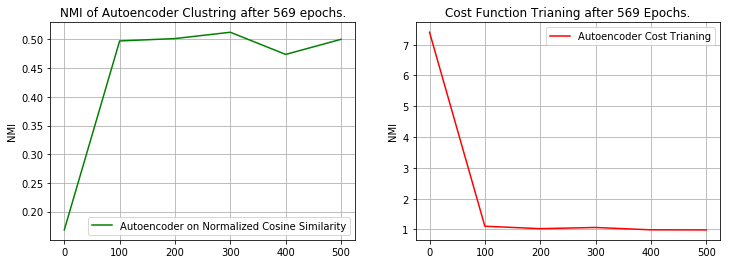

In [19]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.errorbar(steps, results, label='Autoencoder on Normalized Cosine Similarity', color='g')
plt.ylabel('NMI')
plt.grid()
plt.title(('NMI of Autoencoder Clustring after {:d} epochs.').format(n_epoch))
plt.legend(loc='best')
plt.subplot(1, 2, 2)
plt.errorbar(steps, loss_cost, label='Autoencoder Cost Trianing', color='r')
plt.ylabel('NMI')
plt.grid()
plt.title(('Cost Function Trianing after {:d} Epochs.').format(n_epoch))
plt.legend(loc='best')
plt.show()

In [20]:
print("Final Train-Cost:     {:0.2f}".format(new_cost))

Final Train-Cost:     1.06


In [21]:
indx, spec_code= spectral_clustering(data_set_train.whole_dataset()[0], n_component, n_cluster)
spectral_nmi = (normalized_mutual_info_score(data_set_train.whole_dataset()[1], indx))
print(("Spectral CS:          {:0.2f}".format(spectral_nmi)))
#-----------------------------------------------------------------------------------------------
k_means_indx = k_means_(data_set_train.whole_dataset()[0], n_cluster)
k_means_nmi_ = (normalized_mutual_info_score(data_set_train.whole_dataset()[1], k_means_indx))
print(("KMeans CS:            {:0.2f}".format(k_means_nmi_)))
#-----------------------------------------------------------------------------------------------
print("Autoencoder:          {:0.2f}".format(ae_nmi))

Spectral CS:          0.41
KMeans CS:            0.40
Autoencoder:          0.50


In [22]:
warnings.filterwarnings('ignore')
origin_label = np.array(data_set_train.whole_dataset()[1]).astype(int)
colors = [('r', '1'),('b', '2')]

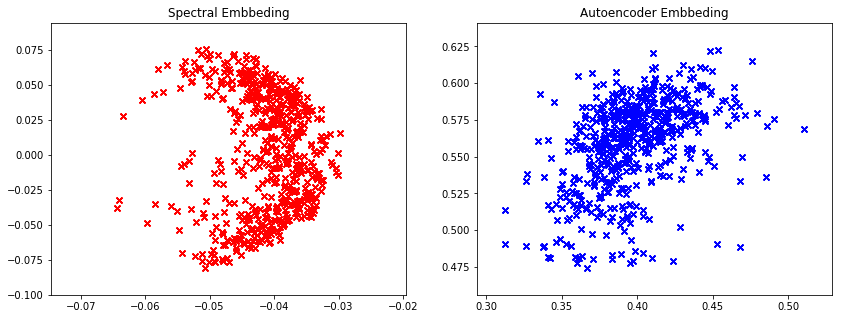

In [23]:
plt.figure(figsize=(14, 5))
for num in range(10):
    plt.subplot(1,2,1)
    plt.scatter(spec_code[:,0], spec_code[:,1], 30, color='r', marker='x')   
    plt.title("Spectral Embbeding")
    plt.legend() 
    plt.subplot(1,2,2)
    plt.scatter(ae_codes[:,0], ae_codes[:,1], 30, color='b', marker='x')
    plt.title("Autoencoder Embbeding")
    plt.legend()
plt.show()

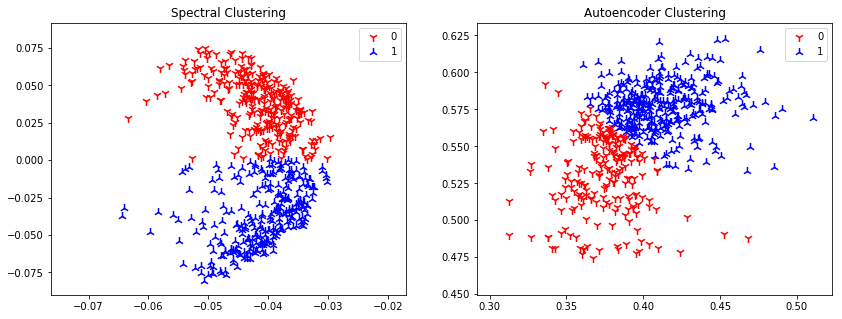

In [24]:
plt.figure(figsize=(14, 5))
for num in range(2):    
    plt.subplot(1,2,1)
    plt.scatter([spec_code[:,0][i] for i in range(len(indx)) if indx[i] == num],
                [spec_code[:,1][i] for i in range(len(indx)) if indx[i] == num],
                80, label=str(num), color = colors[num][0], marker=colors[num][1])        
    plt.title("Spectral Clustering")
    plt.legend()     
    plt.subplot(1,2,2)
    plt.scatter([ae_codes[:,0][i] for i in range(len(idx)) if idx[i] == num],
                [ae_codes[:,1][i] for i in range(len(idx)) if idx[i] == num],
                80, label=str(num), color = colors[num][0], marker=colors[num][1])        
    plt.title("Autoencoder Clustering")
    plt.legend()
plt.show()